# Flappy Bird Optimal Control

<image src="images/poster/Header-removebg.png" style="align: center; width: 500px; height: auto;">

## Imports 

In [15]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import randint

# Abstract
We employ optimal control techniques to create a solution to the popular mobile game Flappy Bird. Our obstacle avoidance model allows the bird to safely navigate through a series of pipes by adding spikes of acceleration to contend with the constant pull of gravity. We formulate this problem with a cost functional that contains a reward and cost component. We reward the control when it successfully guides the bird in between the pipes, and we penalize the control when its shape deviates from a tapping motion. 

# Problem Statement and Motivation
Flappy Bird, a mobile game released in 2013, swiftly ascended to become the most popular free game by January 2014 [`Ang`]. The premise of this addictive game is simple: avoid obstacles. In Flappy Bird, a bird advances forward at a constant pace, and players must guide it through a series of randomly positioned vertical pipes at equally spaced intervals. Users exert control solely over the bird's vertical movement, achieved by tapping the screen to provide a boost to counter the bird's constant descent, necessitating a delicate balance between tapping force and artificial gravity acceleration.

This project aims to optimize the bird's trajectory by determining the optimal moments for screen taps, ensuring safe passage through the obstacles. While prior research has explored optimization strategies for Flappy Bird and similar games, predominantly through deep learning methods like q-networks and genetic algorithms [`Gan22`], our approach distinguishes itself by leveraging optimization and control techniques such as Pontryagin's Maximum Principle. By mathematically modeling the optimal flight path trajectory, our methodology offers a rigorous framework for enhancing gameplay efficiency and performance.

# Methods and Approach
We explore two strategies for maneuvering an object through obstacles. Subsequently, we adjust our control parameters to emulate a discrete tapping motion. 

## Obstacle Avoidance
Our initial approach to obstacle navigation tackles avoiding pipes with defined x and y dimensions. Consequently, the state representation for the Flappy Bird includes both its x and y positions and velocities. This approach necessitates several modifications to the original Obstacle Avoidance lab.

We create a continuous and differentiable obstacle to simulate a pipe by utilizing the equation of an ellipse with a larger radius along the y-axis and a smaller radius along the x-axis. We set our radius along the x-axis to be .1 and then vary the y-axis radius depending on the height of the pipe. $W_1$ serves as a constant that can be adjusted to control the penalty when the bird encounters an obstacle along its path, and the value $\lambda$ specifies the vanishing rate of the penalty.  Putting all of this together yields the following pipe obstacle cost:

\begin{align*}
C(x, y) = \frac{W_1}{\left( \frac{(x - c_x)^2}{r_x} + \frac{(y - c_y)^2}{r_y} \right)^{\lambda} + 1}
\end{align*}

Adding this function penalty to the cost functional deters the bird from navigating near the pipe. Our control $u(t)$ governs the acceleration of the bird in the horizontal and vertical direction. To penalize large acceleration values to mimic the game physics, we add a $W_2 |u(t)|^2$ term to the cost functional, which adds a $W_2$ penalty to large values of $u(t)$. $C_l$ and $C_u$ represent the lower and upper pipe obstacles respectively. Combining these components yields our cost functional and state space:  

\begin{align*}
J[u] = \int_{t_0}^{t_f} \left( 1 + C_l(x(t), y(t)) + C_u(x(t), y(t)) + W_2 |u(t)|^2 \right) \, dt
\end{align*}

\begin{align*}
% state equation
\mathbf{x}'(t) = \begin{bmatrix} x(t) \\ y(t) \\ x'(t) \\ y'(t) \end{bmatrix}',  \quad \mathbf{x}(0) =  \begin{bmatrix} x_0 \\ y_0 \\ 0 \\ 0 \end{bmatrix},  \quad \mathbf{x}(t_f) =  \begin{bmatrix} x_{t_f} \\ y_{t_f} \\ 0 \\ 0 \end{bmatrix}
\end{align*}


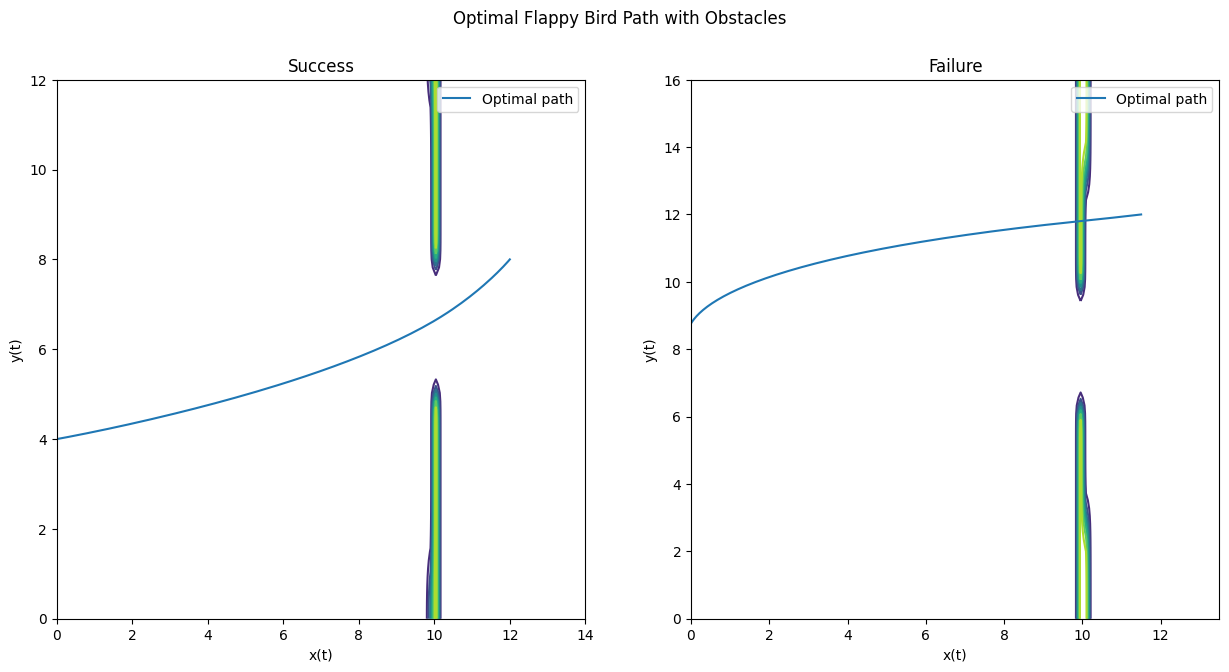

In [16]:
def obstacle(x,y,W1=1,r=(1,1),c=(0,0)):
    '''
    Define an area that will represent an obstacle
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**20 + 1

    return W1 / ellipse

def obstacle_dx(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40* W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

def pipe_avoid_uplow(W1 = 20, W2 = .1, rx = .01, ry = 60, center1 = (7,0), start_location = [0,0], end_location = [7,9]):
    '''
    Calculate and plot the bird's optimal path using obstalces

    Parameters:
        W1 (float): penalty for hitting obstacle 
        W2 (float): penalty for high acceleration 
        rx (float): radius in x direction 
        ry (tuple): radius in y direction
        center1 (tuple): center of the lower pipe ellipse
        start location (list): start location of bird 
        end location (list): end location of bird (which will be adjusted for graphing purposes)
    '''

    center2 = (center1[0], 2*np.sqrt(ry) + 2)
    

    #define X and Y 
    X = np.linspace(start_location[0],end_location[0] + 3,100)
    Y = np.linspace(start_location[1],2 + np.sqrt(ry)*2,100)

    #define y0 
    y0 = 1*np.zeros((8, X.size))


    #define functions
    def fun(t, z):
        return np.vstack((z[2],
                          z[3], 
                          1/(2*W2)*z[6], 
                          1/(2*W2)*z[7],
                          obstacle_dx(z[0],z[1],W1=W1,r=(rx,ry,),c=center1) + obstacle_dx(z[0],z[1],W1=W1,r=(rx,ry,),c=center2),
                          obstacle_dy(z[0],z[1],W1=W1,r=(rx,ry,),c=center1) + obstacle_dy(z[0],z[1],W1=W1,r=(rx,ry,),c=center2), 
                          -z[4],
                          -z[5]))
    
    def bc(ya, yb):
        return np.array([ya[0]- start_location[0], ya[1] - start_location[1], ya[2], ya[3] - 0, yb[0] - (end_location[0] + 1), yb[1] - (end_location[1] - 1), yb[2], yb[3]])
    
    
    #solve and get x and y 
    res_a = solve_bvp(fun, bc, X, y0)

    x1 = res_a.y[0]
    y2 = res_a.y[1]


    #find obstacle 
    X = np.linspace(start_location[0],end_location[0] + 3,100)
    Y = np.linspace(0,2 + np.sqrt(ry)*3,100)
    x_,y_ = np.meshgrid(X,Y)
    obs1 = obstacle(x_,y_,W1=W1,r=(rx,ry),c=center1)
    obs2 = obstacle(x_,y_,W1=W1,r=(rx,ry),c=center2)

    #plot
    plt.contour(x_, y_, obs1)
    plt.contour(x_, y_, obs2)
    plt.plot(x1,y2, label = "Optimal path")
    plt.xlabel("x(t)")
    plt.ylabel("y(t)")
    plt.xlim(start_location[0], end_location[0] + 3)
    plt.ylim(0,end_location[1] + 3)
    plt.legend()
    
# show a successful run
plt.subplot(1, 2, 1)
plt.title("Success")
pipe_avoid_uplow(W1 = 20, W2 = .1, rx = .01, ry = 30, center1 = (10,0), start_location = [0,4], end_location = [11,9])

# show a failed run
plt.subplot(1, 2, 2)
plt.title("Failure")
pipe_avoid_uplow(W1 = 20, W2 = .1, rx = .01, ry = 50, center1 = (10,0), start_location = [0,8], end_location = [10.5,13])

plt.suptitle("Optimal Flappy Bird Path with Obstacles")
plt.gcf().set_size_inches(15, 7)
plt.show()

As seen above, this approach performs well in some situations, but fails in others. The solution's success depends largely on the start and end state locations, so if the bird starts and ends too high, the path will go right through the pipes. Even with large values of $W_2$ the control will guide the bird through the pipes. Because of the narrow shape of the pipes, we infer that the solver prefers quickly passing through the pipe instead of expending the effort to go around the length of the pipe. 

Also, in the actual Flappy Bird game, the user cannot change the $x''(t)$ acceleration since the forward velocity is constant. When we alter this system to have constant x-velocity and no control for the $x''(t)$ term, the numerical solver raises a `Singular Jacobian Matrix` error. This arises from our state-space matrix containing an entire row of zeros (from the constant velocity and zero change in acceleration). To combat this error, we remove the $x(t)$ component in our state-space and restructure the problem as shown in the following section.

## Endpoint Reward

In our second approach, we include a reward for passing in between the obstacle's gap instead of penalizing obstacle location. We begin by setting the final time of the problem to be the moment the bird reaches the middle of the pipes, and then add a negative endpoint cost as depicted in this code and figure:

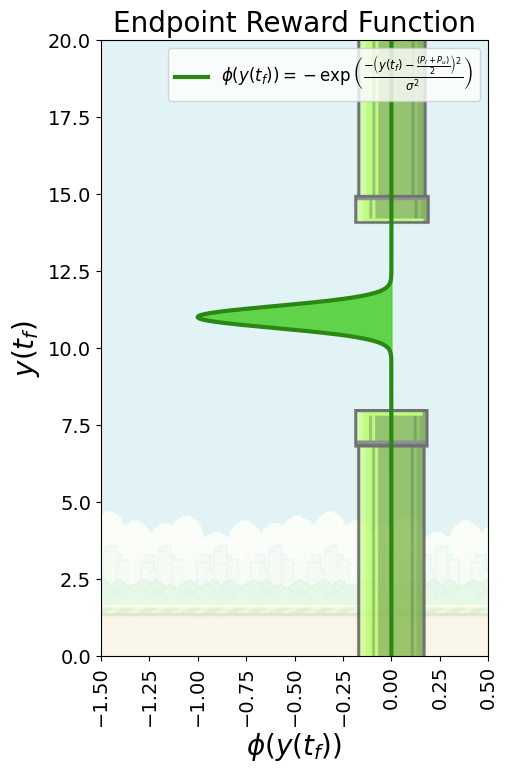

In [17]:
# setup a simple pipe for plotting
pipe_l = 8
pipe_u = 14
sigma2 = 0.5**2
ylims = (0, 20)
xlims = (-1.5, 0.5)

# define the endpoint function and get values for it to plot
def phi(y_tf):
    return -np.exp(-(y_tf - (pipe_l+pipe_u)/2)**2 / sigma2)
domain = np.linspace(ylims[0], ylims[-1], 1000)
xs = np.ones(1000)

# set various plotting parameters for color and transparency
bg_alpha = 0.2
pipe_alpha = 0.75
REWARD_COLOR = "#2b8714"
REWARD_COLOR_FILL = "#41cc1f"
plt.xlim(*xlims)
plt.ylim(*ylims)

# plot the reward function with an appropriate label
equation_latex = r"$\phi (y(t_f)) = - \exp\left(\frac{-\left(y(t_f) - \frac{(P_l+P_u)}{2}\right)^2}{\sigma^2}\right)$"
plt.plot(phi(domain), domain, REWARD_COLOR, linewidth=3, label=equation_latex)
plt.fill_betweenx(domain, phi(domain), x2=0, color=REWARD_COLOR_FILL, alpha=0.8)

# plot the background
background = mpimg.imread('images/used/background.jpg')
h, w, c = background.shape
background = background[:, :int(w // 3), :]
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=bg_alpha)

# plot the lower pipe
width = 0.2
xmin, xmax = 0-width, 0+width
ymin, ymax = ylims[0], pipe_l
img = mpimg.imread('images/used/pipe_lower_long.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', alpha=pipe_alpha)

# plot the upper pipe
xmin, xmax = 0-width, 0+width
ymin, ymax = pipe_u, ylims[1]
img = mpimg.imread('images/used/pipe_upper_long.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', alpha=pipe_alpha)

plt.gcf().set_size_inches(5, 8)
plt.title("Endpoint Reward Function", fontsize=20)
plt.xlabel(r"$\phi(y(t_f))$", fontsize=20)
plt.ylabel(r"$y(t_f)$", fontsize=20)
plt.xticks(fontsize=14, rotation=90)

plt.yticks(fontsize=14)

plt.legend(fontsize='large')

plt.savefig("images/poster/reward.png", dpi=100, bbox_inches="tight")

plt.show()

Our endpoint cost function 
\begin{align*}
\phi (y(t_f)) = - \exp\left(\frac{-\left(y(t_f) - \frac{(P_l+P_u)}{2}\right)^2}{\sigma^2}\right)
\end{align*}
is similar to a rotated Gaussian distribution. We set the mean of the Gaussian to be the center location between the pipes $\frac{(P_l+P_u)}{2}$, and we set the variance $\sigma^2$ to a small number ($0.1^2$). This pushes the bird's path between the two pipes without forcing it to end exactly at a certain point; thus, the model is able to adjust and account for circumstances in which slightly different endpoints are needed without violating the laws of the model. 

Along with adding an endpoint cost, we also adjust our state equations to remove the $x(t)$ dependence. This not only avoids the `Singular Jacobian Matrix` error, but also simplifies the model for quicker convergence. Our initial state includes a specified vertical position and zero velocity. Our endpoint state incorporates a free variable for the bird's final vertical position. This allows the endpoint incentive to adapt to various game conditions. We also specify zero velocity at the endpoint in order to chain multiple sub-problems together (see the multiple pipes section for an implementation of this). Finally, we add a running cost $\frac{1}{2}u(t)^2$ to our functional to penalize large values of the control in order to simulate the constrained physics of the game.

Putting the endpoint reward and new state-space equations together, our new cost functional and state space are:
\begin{align*}
    J[u] &= \int_{t_0}^{t_f} \frac{1}{2}u(t)^2 \, dt - \exp\left(\frac{-\left(y(t_f) - \frac{(P_l+P_u)}{2}\right)^2}{\sigma^2}\right)
\end{align*}

\begin{align*}
\mathbf{x}'(t) &= \begin{bmatrix} y(t) \\ y'(t) \end{bmatrix}' =  \begin{bmatrix} y'(t) \\ u(t) - 9.8 \end{bmatrix}, \quad \mathbf{x}(0) = \begin{bmatrix} y_0 \\ 0 \end{bmatrix}, \quad \mathbf{x}(t_f) = \begin{bmatrix} \text{free} \\ 0 \end{bmatrix}
\end{align*}
We demonstrate the solution to this successful system in the following code and figures.


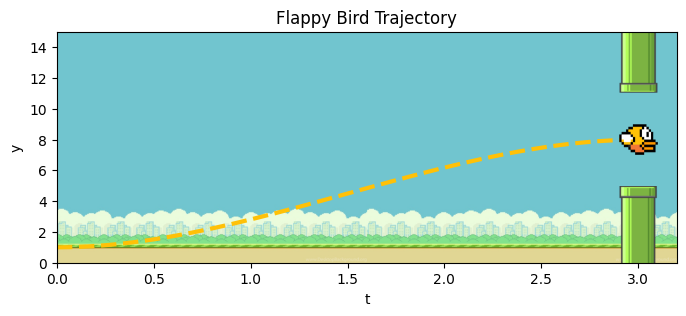

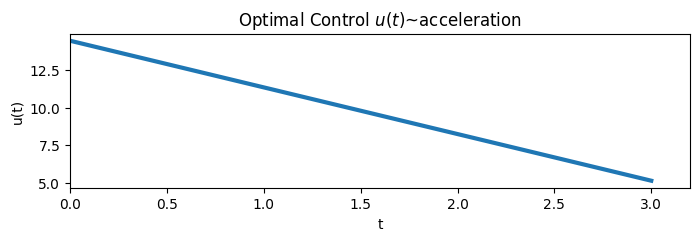

In [18]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

# setup the parameters for the problem
t0, tf = 0, 3
L, U = 5, 11
sigma2 = 0.1**2
Sy = 1
g = 9.8
END_REWARD = 1

# determine how long to run the BVP solver
t_span = (t0, tf)
t_steps = 100
t = np.linspace(t_span[0], t_span[1], t_steps)

# define the endpoint function and its derivative
def phi(y_tf):
    return -END_REWARD * np.exp(-(y_tf - (L+U)/2)**2 / sigma2)
def phi_d(y_tf):
    return END_REWARD * (2/sigma2) * (y_tf - (L+U)/2) * phi(y_tf)

# setup the ode and boundary conditions for this problem
def ode(t, y_var):
    y, yp, p0, p1 = y_var
    u = p1
    zeros = np.zeros_like(y)
    ones = np.ones_like(y)
    return np.array([
        yp,         # y' = y'
        u - ones*g, # y'' = u - g
        zeros,      # p0' = -DH/Dy = 0
        -p0         # p1' = -DH/Dy' = -p0
    ])
def bc(ya, yb):
    y_tf = yb[0]
    return np.array([
        ya[0] - Sy,         # y(0) = Sy
        ya[1] - 0,          # y'(0) = 0
        yb[1] - 0,          # y'(tf) = 0
        yb[2] - phi_d(y_tf) # p0(tf) = - Dphi/Dy(tf)
    ])

# setup an intial guess for the solution
y_guess = np.linspace(Sy, (U+L)/2, t_steps)
yp_guess = np.ones(t_steps)*(((U+L)/2 - Sy) / (tf - t0))
p0_guess = np.zeros(t_steps)
p1_guess = np.ones(t_steps)
y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

# solve the solution with the ode, bc, and initial guess
sol = solve_bvp(ode, bc, t, y0)

# extract the values from the solution
y = sol.y[0]
yp = sol.y[1]
p0 = sol.y[2]
p1 = sol.y[3]

# compute the optimal control
u = p1

############################################################
#                     PLOT THE RESULTS                     #
############################################################

PATH_COLOR = "#ffc107"

# setup the plot
plt.title("Flappy Bird Trajectory")
plt.gcf().set_size_inches(8,3)
xlims = (0, 3.2)
ylims = (0, 15)
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.xlabel("t")
plt.ylabel("y")

# plot the trajectory
plt.plot(t, y, "--", linewidth=3, color=PATH_COLOR)

# plot the background
background = mpimg.imread('images/used/background.jpg')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the upper pipe
xmin, xmax = 2.9, 3.1
ymin, ymax = U, ylims[1]
img = mpimg.imread('images/used/pipe_upper_long.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the lower pipe
xmin, xmax = 2.9, 3.1
ymin, ymax = ylims[0], L
img = mpimg.imread('images/used/pipe_lower_long.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the bird
xmin, xmax = 2.9, 3.1
ymin, ymax = 7, 9
bird = mpimg.imread('images/used/bird.png')
plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)
plt.show()

# plot the u(t)
plt.title("Optimal Control $u(t)$~acceleration")
plt.plot(t, u, linewidth=3)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)
plt.show()

As seen in this figure,  the bird successfully navigates through the center of the pipes, so the reward and state-space equations converge to a valid solution. This straight line control causes the bird to smoothly glide through the middle of the pipe. 

## Guiding the Control
In the actual Flappy Bird game, the user can not control the bird with a smooth acceleration; rather, the user taps the screen at distinct times to give the bird large spikes of acceleration. To realistically model this aspect of the game, we must guide the continuous control function to mimic distinct taps experienced during game play.

To accomplish this, we change the running-cost in our functional by penalizing the shape of the control instead of large values of the control. We do this by first engineering a function $f(t)$ that resembles a sequence of taps, and then we add a penalty $W(u(t) - f(t))^2$ to the running cost. This penalizes the control when its shape does not match $f(t)$'s shape for each $t$. We use the continuous function $f(t) = \beta\max\{0, \sin(\alpha t)\}$, which only recognizes the positive portion of the sine wave. By manipulating the amplitude ($\beta$) and wavelength ($\alpha$) of the sine component, the function results in a continuous series of sharp spikes that simulate discrete taps. 

With these additional adjustments, our final cost functional is:
\begin{align*}
    J[u] &= \int_{t_0}^{t_f} W \left[u(t) - \beta \max\{0, \sin(\alpha t)\} \right]^2 \, dt - \exp\left(\frac{-\left(y(t_f) - \frac{(P_l+P_u)}{2}\right)^2}{\sigma^2}\right)
\end{align*}
where the running cost inside the integral guides the control to look like discrete taps, and the endpoint cost acts as a reward when the bird successfully flies through the middle of the pipes.

We define our Hamiltonian as follows:

\begin{align*}
H = \mathbf{p} \cdot \mathbf{f} - L 
 = p_0 y'(t) + p_1 (u(t) - 9.8) - W\left[u(t) - \beta\max\{0, \sin(\alpha t)\} \right]^2
\end{align*}
The Hamiltonian captures the total energy of the system, taking into account the dynamics of the state variables ($y'$ and $u$) and their conjugate momenta ($p_0$ and $p_1$), as well as the Lagrangian ($L$), which represents our runtime cost.

Following Pontryagin's Maximum Principle, we solve for our costate equations as follows:

\begin{align*}
p_0' &= -\frac{\partial H}{\partial y} = 0 \\
p_1' &= -\frac{\partial H}{\partial y'} = -p_0
\end{align*}
The costate equations describe the evolution of the costate variables $p_0$ and $p_1$ over time, reflecting how changes in the Hamiltonian affect their dynamics.

At the final time $t_f$, the costates are given by:

\begin{align*}
p_0(t_f) &= -\frac{\partial \phi}{\partial y(t_f)} = \left(\frac{-( 2y(t_f) - (P_l+P_u))}{\sigma^2}\right)  \exp\left(\frac{-\left(y(t_f) - \frac{(P_l+P_u)}{2}\right)^2}{\sigma^2}\right) \\
p_1(t_f) &= \text{free}
\end{align*}
The costates at the final time provide insight into the terminal conditions required for optimal control, with $p_0(t_f)$ encoding the sensitivity of the cost to changes in the final state $y(t_f)$.

Finally, we compute the optimal control input $\tilde{u}$ by maximizing the Hamiltonian with respect to $u$:

\begin{align*}
\frac{ \partial H}{\partial u} = 0 = p_1 + 2W \left[ u(t) - \beta \max\{0, \sin(\alpha t)\} \right] \\
\implies \tilde{u} = \beta \max\{0, \sin(\alpha t)\} -\frac{p_1}{2W}
\end{align*}

We determine the optimal control input $\tilde{u}$ by balancing the cost associated with deviations from the desired trajectory $\beta\max\{0, \sin(\alpha t)\}$ against the benefits of achieving desired state transitions.

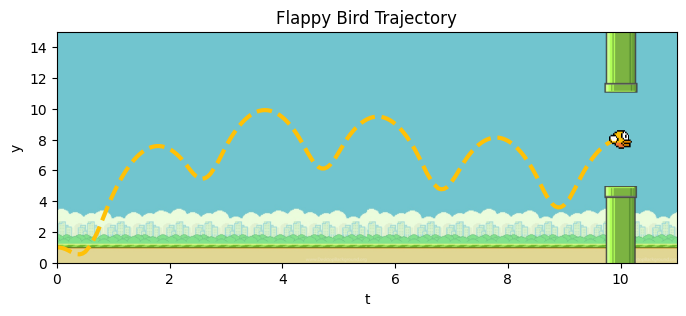

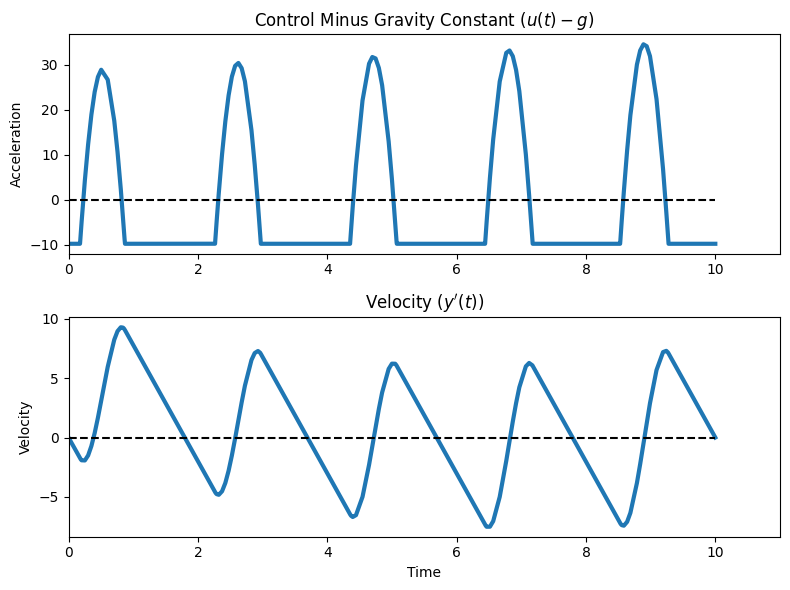

In [19]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

def get_sol(t0=0, tf=10, pipe_l=5, pipe_u=11, start_y=1, g=20, alpha=2, beta=0.8, sigma2=0.1**2, sine_weight=10, verbose=0):
    
    # determine how long to run the BVP solver
    t_steps = 100
    t = np.linspace(t0, tf, t_steps)

    # define the endpoint function and its derivative
    def phi(y_tf):
        return -np.exp(-(y_tf - (pipe_l+pipe_u)/2)**2 / sigma2)
    def phi_d(y_tf):
        return (2/sigma2) * (y_tf - (pipe_l+pipe_u)/2) * phi(y_tf)

    # define the control relation to the co-state (comes from
    # the Lagrangian [u - sin(alpha t)]^2)
    def control(p1, t):
        sin_part = np.sin(alpha*t)
        sin_part = np.clip(sin_part, 0, np.abs(sin_part))
        res = -p1/2 + beta*sin_part
        res = np.clip(res, 0, np.abs(res))
        return res*sine_weight

    # setup the ode and boundary conditions for this problem
    def ode(t, y_var):
        y, yp, p0, p1 = y_var
        
        u = control(p1, t)
        
        zeros = np.zeros_like(y)
        ones = np.ones_like(y)
        return np.array([
            yp,         # y' = y'
            u - ones*g, # y'' = u - g
            zeros,      # p0' = -DH/Dy = 0
            -p0         # p1' = -DH/Dy' = -p0
        ])
    def bc(ya, yb):
        y_tf = yb[0]
        return np.array([
            ya[0] - start_y,         # y(0) = Sy
            ya[1] - 0,          # y'(0) = 0
            yb[1] - 0,          # y'(tf) = 0
            yb[2] - phi_d(y_tf) # p0(tf) = - Dphi/Dy(tf)
        ])

    # setup an intial guess for the solution
    y_guess = np.linspace(start_y, (pipe_u+pipe_l)/2, t_steps)
    yp_guess = np.ones(t_steps)*(((pipe_u+pipe_l)/2 - start_y) / (tf - t0))
    p0_guess = np.zeros(t_steps)
    p1_guess = np.sin(alpha*np.linspace(t0, tf, t_steps))
    y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

    # solve the solution with the ode, bc, and initial guess
    sol = solve_bvp(ode, bc, t, y0, verbose=verbose)

    # extract the values from the solution
    t = sol.x
    y = sol.y[0]
    yp = sol.y[1]
    p0 = sol.y[2]
    p1 = sol.y[3]

    # compute the optimal control
    u = control(p1, t)
    
    return {'t':t, 'y':y, 'yp':yp, 'p0':p0, 'p1':p1, 'u':u, 'accel':u - g}


# setup the parameters for the problem
t0, tf = 0, 10
L, U = 5, 11
sigma2 = 0.1**2
Sy = 1
g = 9.8
END_REWARD = 1

alpha = 3
beta = 0.8*g
sine_weight = 10

# determine how long to run the BVP solver
t_span = (t0, tf)
t_steps = 100
t = np.linspace(t_span[0], t_span[1], t_steps)

sol = get_sol(t0=t0, tf=tf, pipe_l=L, pipe_u=U, start_y=Sy, g=g, alpha=alpha, beta=beta, sigma2=sigma2, sine_weight=sine_weight, verbose=0)

# extract the values from the solution
t = sol['t']
y = sol['y']
yp = sol['yp']
p0 = sol['p0']
p1 = sol['p1']
accel = sol['accel']
u = sol['u']

############################################################
#                     PLOT THE RESULTS                     #
############################################################

PATH_COLOR = "#ffc107"

# setup the plot
plt.title("Flappy Bird Trajectory")
plt.gcf().set_size_inches(8,3)
xlims = (0, tf+1)
ylims = (0, 15)
plt.xlim(*xlims)
plt.ylim(*ylims)
plt.xlabel("t")
plt.ylabel("y")

# plot the trajectory
plt.plot(t, y, "--", linewidth=3, color=PATH_COLOR)

# plot the background
background = mpimg.imread('images/used/background.jpg')
plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

# plot the upper pipe
PIPE_WIDTH = 0.3
xmin, xmax = tf-PIPE_WIDTH, tf+PIPE_WIDTH
ymin, ymax = U, ylims[1]
img = mpimg.imread('images/used/pipe_upper_long.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the lower pipe
xmin, xmax = tf-PIPE_WIDTH, tf+PIPE_WIDTH
ymin, ymax = ylims[0], L
img = mpimg.imread('images/used/pipe_lower_long.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

# plot the bird
BIRD_SIZE = PIPE_WIDTH / 1.5
xmin, xmax = t[-1]-BIRD_SIZE, t[-1]+BIRD_SIZE
ymin, ymax = y[-1]-BIRD_SIZE*3, y[-1]+BIRD_SIZE*3
img = mpimg.imread('images/used/bird.png')
plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)
plt.show()

# plot the u(t)
plt.subplot(2, 1, 1)
plt.title("Control Minus Gravity Constant ($u(t)-g$)")
plt.plot(t, accel, linewidth=3, label="$u(t)-g$")
plt.hlines(0, 0, tf, color="black", linestyle="--")
plt.ylabel("Acceleration")
plt.xlim(*xlims)
plt.gcf().set_size_inches(8,2)

# plot the velocity
plt.subplot(2, 1, 2)
plt.title("Velocity ($y'(t)$)")
plt.plot(t, yp, linewidth=3)
plt.hlines(0, 0, tf, color="black", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.xlim(*xlims)

plt.gcf().set_size_inches(8,6)
plt.tight_layout()
plt.show()

The Flappy Bird Trajectory plot shows that the bird successfully ends in between the two pipes, and its course appears as the path in the actual game. The acceleration plot demonstrates that when the control is zero, the bird is accelerating at $-9.8$ which is the gravitational constant. The velocity plot shows how the bird alternates between going up and down like the actual physics in the game. 

# Interpretation
Our final model successfully navigates pipes of varying heights and starting positions. We acknowledge extensive hyperparameter tuning specific to the Flappy Bird game was necessary. These parameters include frequency, amplitude, and weights. Adjusting these hyperparameters to deviate from the game scenario leads to performance degradation. For instance, doubling the wavelength causes the bird to glide towards the pipes on a smooth trajectory instead of a jagged path like in the actual game. Similarly, increasing the amplitude guides the bird to the pipe center without considering collisions, and the bird often will intersect the pipe obstacles.

## Multiple Pipes

To simulate the game by guiding the bird through a sequence of random pipes, we break the multiple-pipe problem into sub-problems (start-pipe1, pipe1-pipe2, etc.). We then use solve\_bvp on each subsection where the current section's initial conditions are set to the final state of the previous solution. Finally, we concatenate all of the data from these solutions into one large plot, and add the pipes in the appropriate locations. 

In [20]:
############################################################
#            DEFINE THE MULTIPLE PIPES FUNCTION           #
############################################################

def multiple_pipes_sol(pipe_ls=None, PIPE_GAP=6, g=9.8, alpha=3, 
                 beta=0.9, sine_weight=10, sigma2=1**2, num_pipes=5, 
                 pipe_dist=7, start_y=10):

    # setup parameters for the physics of the game
    if pipe_ls is None:
        pipe_ls = []
        while len(pipe_ls) < num_pipes:
            p = randint(2, 12)
            if len(pipe_ls) == 0 or (abs(p - pipe_ls[-1]) <= 6 and p not in pipe_ls):
                pipe_ls.append(p)
                
    else:
        pipe_ls = pipe_ls[:num_pipes]
    num_pipes = len(pipe_ls)

    # define the initial starting point and where the pipes are
    pipe_ts = (np.arange(num_pipes)*PIPE_GAP + PIPE_GAP).tolist()
    pipe_us = [p + PIPE_GAP for p in pipe_ls]
    times = [0] + pipe_ts

    # compute a relative pipe width based on the time between pipes
    PIPE_WIDTH = (times[-1] - times[0]) / 30

    # compute the solution between each pair of pipes
    curr_y = start_y
    ts, ys, us, accels, velocities = [], [], [], [], []
    for t0, tf, pipe_l, pipe_u in zip(times[:-1], times[1:], pipe_ls, pipe_us):
        
        # use solve_bvp to get the solution between these two pipes
        sol = get_sol(t0, tf, pipe_l, pipe_u, curr_y, 
                    g=g, alpha=alpha, beta=beta, 
                    sine_weight=sine_weight)
        
        # concatenate the results from this segment to the previous segments
        ts += sol['t'].tolist()
        ys += sol['y'].tolist()
        us += sol['u'].tolist()
        accels += sol['accel'].tolist()
        velocities += sol['yp'].tolist()
        
        # start the y where we left off
        curr_y = ys[-1]
        
    return {'ts':ts, 'ys':ys, 'us':us, 'accels':accels, 
            'velocities':velocities, 'pipe_ts':pipe_ts, 
            'pipe_ls':pipe_ls, 'pipe_us':pipe_us,
            'times': times, 'PIPE_WIDTH': PIPE_WIDTH}
    
def plot_multiple_pipes(pipe_ls=None, PIPE_GAP=6, g=9.8, alpha=3, 
                 beta=0.9, sine_weight=10, sigma2=1**2, num_pipes=5, 
                 pipe_dist=7, start_y=10, BIRD_HEIGHT_MULT=1):

    # get a multiple pipe solution
    res = multiple_pipes_sol(pipe_ls=pipe_ls, PIPE_GAP=PIPE_GAP, g=g, alpha=alpha,
                             beta=beta, sine_weight=sine_weight, sigma2=sigma2,
                             num_pipes=num_pipes, pipe_dist=pipe_dist, start_y=start_y)
    ts = res['ts']
    ys = res['ys']
    us = res['us']
    accels = res['accels']
    velocities = res['velocities']
    pipe_ts = res['pipe_ts']
    pipe_ls = res['pipe_ls']
    pipe_us = res['pipe_us']
    times = res['times']
    PIPE_WIDTH = res['PIPE_WIDTH']
        
    ############################################################
    #                     PLOT THE RESULTS                     #
    ############################################################

    # plot the results
    Y_PLOT_LIMS = (0, 20)
    PATH_COLOR = "#ffc107"

    # setup the plot
    plt.title("Flappy Bird Trajectory", fontsize=20)
    plt.gcf().set_size_inches(10,5)
    xlims = (times[0], times[-1]+2)
    ylims = Y_PLOT_LIMS
    plt.xlim(*xlims)
    plt.ylim(*ylims)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("$y(t)$", fontsize=14)

    # plot the trajectory
    plt.plot(ts, ys, "--", linewidth=3, color=PATH_COLOR)

    # plot the background
    background = mpimg.imread('images/used/background.jpg')
    plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

    # plot the lower pipes
    for pipe_t, pipe_l in zip(pipe_ts, pipe_ls):
        # load the image
        img = mpimg.imread('images/used/pipe_lower_long.png')
        # find the x and y limits for the pipe
        xmin, xmax = pipe_t-PIPE_WIDTH, pipe_t+PIPE_WIDTH
        ymin, ymax = ylims[0], pipe_l
        # truncate the image to only show the right amount of pipe
        ratio = (ymax - ymin) / 10
        h, w, c = img.shape
        img_h = int(h * ratio)
        img = img[:img_h, :, :]
        # add the iamge to the plot
        plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')
        
    # plot the upper pipes
    for pipe_t, pipe_u in zip(pipe_ts, pipe_us):
        # load the image
        img = mpimg.imread('images/used/pipe_upper_long.png')
        # find the x and y limits for the pipe
        xmin, xmax = pipe_t-PIPE_WIDTH, pipe_t+PIPE_WIDTH
        ymin, ymax = pipe_u, ylims[1]
        # truncate the image to only show the right amount of pipe
        ratio = (ymax - ymin) / 10
        h, w, c = img.shape
        img_h = int(h * ratio)
        img = img[-img_h:, :, :]
        # add the iamge to the plot
        plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')
        
    # plot the bird
    BIRD_SIZE = PIPE_WIDTH / 1.5
    xmin, xmax = ts[-1]-BIRD_SIZE, ts[-1]+BIRD_SIZE
    ymin, ymax = ys[-1]-BIRD_SIZE*BIRD_HEIGHT_MULT, ys[-1]+BIRD_SIZE*BIRD_HEIGHT_MULT
    img = mpimg.imread('images/used/bird.png')
    plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)

    # save the figure to a file with really high quality
    plt.savefig("images/poster/flappy_bird_trajectory.png", dpi=600, bbox_inches="tight")
    plt.show()

    # plot the control verses time plot
    plt.title(r"Control $\tilde{u}(t)$", fontsize=20)
    plt.gcf().set_size_inches(10,1.5)
    xlims = (times[0], times[-1]+2)
    plt.xlim(*xlims)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Acceleration", fontsize=14)
    plt.plot(ts, np.array(us)-9.8, linewidth=3)
    plt.hlines(0, times[0], times[-1]+2, color='black', linestyle='--')
    

    plt.savefig("images/poster/control.png", dpi=600, bbox_inches="tight")
    plt.show()

    # plot the velocity verses time plot with a horizontal line at 0
    plt.title(r"Velocity $y'(t)$", fontsize=20)
    plt.gcf().set_size_inches(10,1.5)
    xlims = (times[0], times[-1]+2)
    plt.xlim(*xlims)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Velocity", fontsize=14)
    plt.plot(ts, velocities, linewidth=3)
    plt.axhline(0, color='black', linestyle='--')

    plt.savefig("images/poster/velocity.png", dpi=600, bbox_inches="tight")
    plt.show()

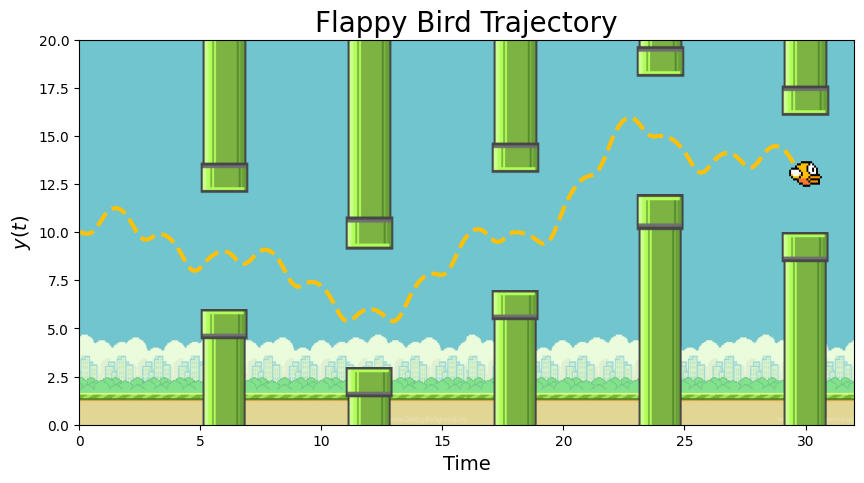

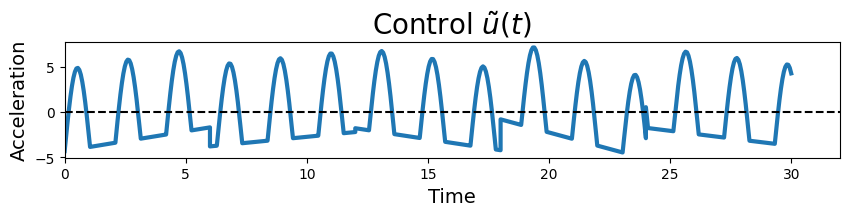

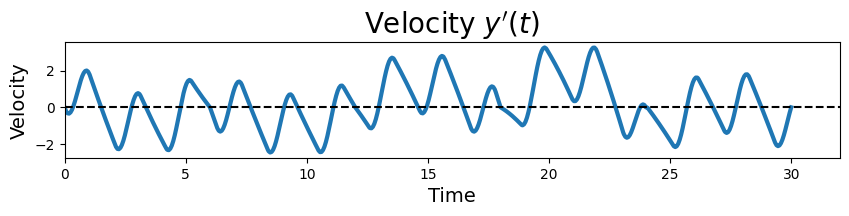

In [21]:
plot_multiple_pipes(pipe_ls=[6, 3, 7, 12, 10])

As seen in this figure, our model produces a valid solution that both avoids the pipes, and also successfully models the flow of the game. On top of this, our optimal control successfully navigates any choice of pipe locations. 

While this approach produces a valid solution which accurately navigates the pipes, this may not be the optimal solution overall. This is reflected in the control, which exhibits jagged jumps as the algorithm transitions between solutions for individual pipe pairs. These jumps occur because we enforce zero velocity at the start and end of each sub-problem, resulting in unnatural movements for the bird.

# Conclusion
This project seeks to find the most efficient path for a Flappy Bird to navigate through a series of pipe obstacles. Our first approach focuses on obstacle avoidance. In performing this, we begin with a cost functional that incorporates the obstacles in our functional and penalizes the area of the obstacles. In developing these early stages of our model, we encounter several hurdles in solving our functional, including Singular Jacobian matrices. Upon restructuring our state space to solely include the vertical velocity and acceleration, we identify the constant horizontal velocity as the root of these errors. Leveraging Pontryagin's Maximum Principle as well as addressing these initial "obstacles", we successfully create an algorithm to beat the Flappy Bird game. Rather than penalizing obstacle areas, we utilize a Gaussian distribution to incentivize the bird to pass through the pipes. In order to simulate the discrete tapping motion of the bird through the obstacles, we also incorporate a guide to the control. This combination of tapping motion and endpoint reward results in a successful model. Future model iterations could include structuring a control function that would be able to vary in frequency. This would allow the model to dynamically adjust the timing of taps, leading to more natural and efficient obstacle navigation. 

Our current approach simulates the multi-pipe Flappy Bird scenario by sequentially solving for the optimal path between individual pipes. These solutions are then combined to form a complete trajectory.  While this method successfully navigates the game and avoids collisions, future research could explore finding the optimal path through a sequence of pipes in one solution, potentially leading to a more efficient approach compared to the current piece-wise approach.

# References 

[Ang] Alex Angry. The flappy bird phenomenon: A story about dependency
in the app store.

[Gan22] R. Gan. Flappy bird: Optimization of deep q-network by genetic algo-
rithm. In 2022 IEEE International Conference on Artificial Intelligence
and Computer Applications (ICAICA), pages 703–707, Dalian, China,
2022

# Appendix

### Hyperparameter example - alpha is too high

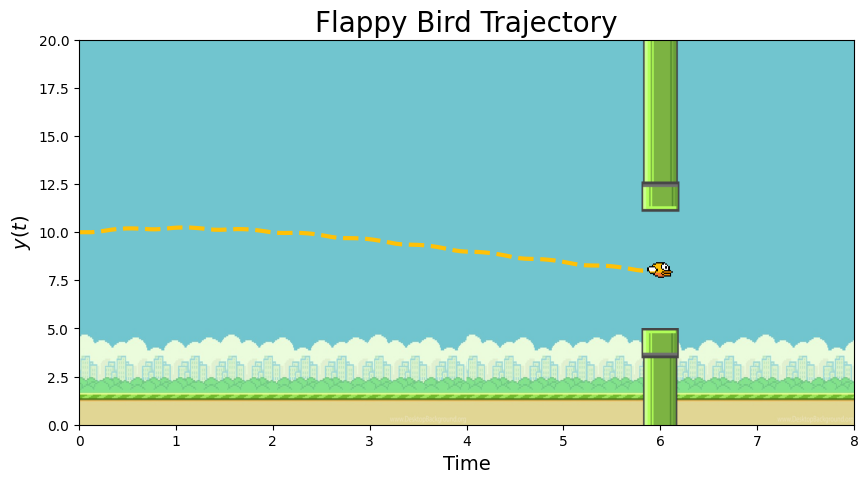

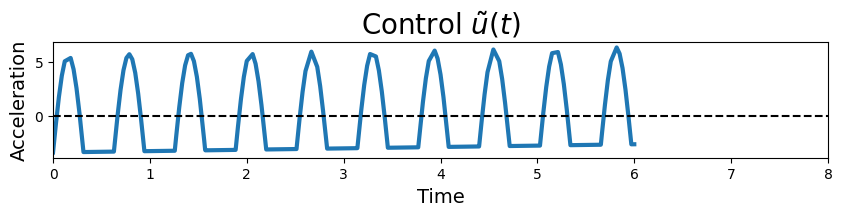

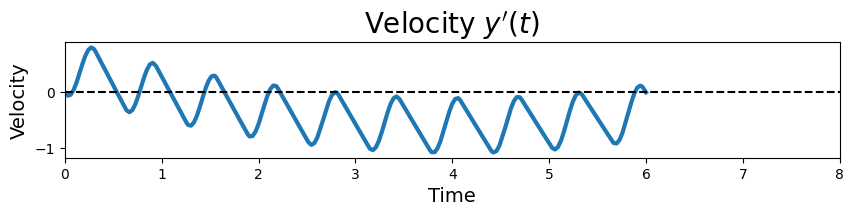

In [22]:
plot_multiple_pipes(alpha=10, pipe_ls=[5], BIRD_HEIGHT_MULT=3)

### create the animation

In [23]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.ndimage import rotate
from random import randint
from random import randint
animation.writer = animation.writers['ffmpeg']

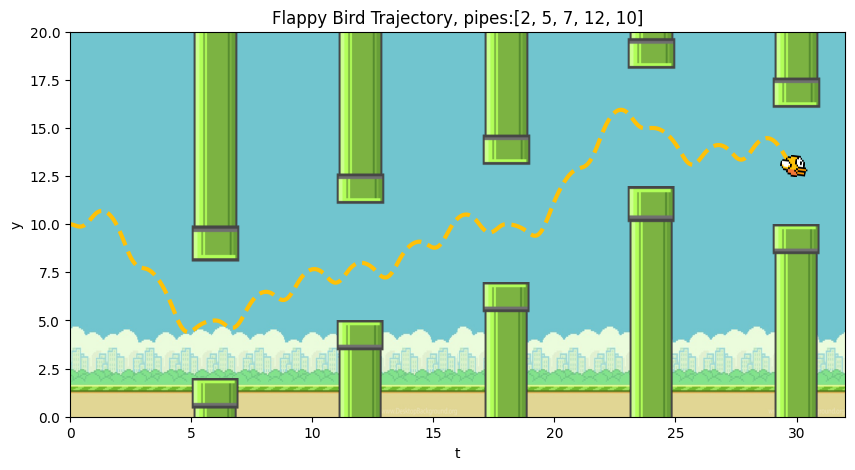

In [26]:
############################################################
#             SETUP THE BOUNDARY VALUE PROBLEM             #
############################################################

def gen_ran_anim(pipe_ls=None, PIPE_GAP=6, g=9.8, alpha=3, 
                 beta=0.9, sine_weight=10, sigma2=1**2, num_pipes=5, 
                 pipe_dist=7, start_y=10):

    ############################################################
    #                     PLOT THE RESULTS                     #
    ############################################################

    # get a multiple pipe solution
    res = multiple_pipes_sol(pipe_ls=pipe_ls, PIPE_GAP=PIPE_GAP, g=g, alpha=alpha,
        beta=beta, sine_weight=sine_weight, sigma2=sigma2,
        num_pipes=num_pipes, pipe_dist=pipe_dist, start_y=start_y)
    ts = res['ts']
    ys = res['ys']
    us = res['us']
    accels = res['accels']
    velocities = res['velocities']
    pipe_ts = res['pipe_ts']
    pipe_ls = res['pipe_ls']
    pipe_us = res['pipe_us']
    times = res['times']
    PIPE_WIDTH = res['PIPE_WIDTH']
    
    plt.clf()
    
    # setup all of the parameters for the problem
    Y_PLOT_LIMS = (0, 20)
    PATH_COLOR = "#ffc107"

    # setup the plot
    plt.title(f"Flappy Bird Trajectory, pipes:{pipe_ls}")
    plt.gcf().set_size_inches(10,5)
    xlims = (times[0], times[-1]+2)
    ylims = Y_PLOT_LIMS
    plt.xlim(*xlims)
    plt.ylim(*ylims)
    plt.xlabel("t")
    plt.ylabel("y")

    # plot the background
    background = mpimg.imread('images/used/background.jpg')
    plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)

    # plot the lower pipes
    for pipe_t, pipe_l in zip(pipe_ts, pipe_ls):
        # load the image
        img = mpimg.imread('images/used/pipe_lower_long.png')
        # find the x and y limits for the pipe
        xmin, xmax = pipe_t-PIPE_WIDTH, pipe_t+PIPE_WIDTH
        ymin, ymax = ylims[0], pipe_l
        # truncate the image to only show the right amount of pipe
        ratio = (ymax - ymin) / 10
        h, w, c = img.shape
        img_h = int(h * ratio)
        img = img[:img_h, :, :]
        # add the iamge to the plot
        plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')
        
    # plot the upper pipes
    for pipe_t, pipe_u in zip(pipe_ts, pipe_us):
        # load the image
        img = mpimg.imread('images/used/pipe_upper_long.png')
        # find the x and y limits for the pipe
        xmin, xmax = pipe_t-PIPE_WIDTH, pipe_t+PIPE_WIDTH
        ymin, ymax = pipe_u, ylims[1]
        # truncate the image to only show the right amount of pipe
        ratio = (ymax - ymin) / 10
        h, w, c = img.shape
        img_h = int(h * ratio)
        img = img[-img_h:, :, :]
        # add the iamge to the plot
        plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')
        
    # plot the bird
    BIRD_SIZE = PIPE_WIDTH / 1.75
    xmin, xmax = ts[-1]-BIRD_SIZE, ts[-1]+BIRD_SIZE
    ymin, ymax = ys[-1]-BIRD_SIZE, ys[-1]+BIRD_SIZE
    img = mpimg.imread('images/used/bird.png')

    # plot the trajectory
    line, = plt.gca().plot([], [], "--", linewidth=3, color=PATH_COLOR)

    # Plot initial position of the bird
    bird = plt.imshow(img, extent=[ts[0] - BIRD_SIZE, ts[0] + BIRD_SIZE, ys[0] - BIRD_SIZE, ys[0] + BIRD_SIZE], aspect='auto', zorder=2)

    # Rotate bird image based on velocity
    def rotate_bird(velocity):
        angle = np.degrees(np.arctan(velocity / 5))
        rotated_img = rotate(img, angle, reshape=False)
        rotated_img = np.clip(rotated_img, 0, 1)
        return rotated_img

    # Define update function
    def update(frame):
        print(frame, "/", len(ts), end="\r")
        # Update trajectory
        line.set_data(ts[:frame], ys[:frame])
        
        # Update bird position and rotation relative to velocity
        velocity = velocities[frame]
        bird.set_data(rotate_bird(velocity))
        
        # Update bird position
        bird.set_extent([ts[frame] - BIRD_SIZE, ts[frame] + BIRD_SIZE, ys[frame] - BIRD_SIZE, ys[frame] + BIRD_SIZE])

    ani = FuncAnimation(plt.gcf(), update, frames=range(0, len(ts), 5), interval=60, repeat=False)
    ani.save("images/animation_" + "_".join([str(p) for p in pipe_ls]) + ".mp4")

def gen_pipe_list(num_pipes):
    """ this generates a random list of pipes that is possible
    for the bird to get through. The pipes need to be between 2 and 12
    and it works best if the pipe gap is not larger than 6. The animation
    also looks more interesting if a pipe location has not already been seen
    """
    pipe_ls = []
    while len(pipe_ls) < num_pipes:
        p = randint(2, 12)
        if len(pipe_ls) == 0 or (abs(p - pipe_ls[-1]) <= 6 and p not in pipe_ls):
            pipe_ls.append(p)
    return pipe_ls

pipes_list = gen_pipe_list(5)
pipes_list = [2, 5, 7, 12, 10] # ADJUST THIS TO SEE DIFFERENT ANIMATIONS!
gen_ran_anim(pipes_list)